# Определение перспективного тарифа для телеком компании

Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Шаг 1. Откройте файл с данными и изучите общую информацию

Импортируем все нужные для дальнейшего использования библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats as st

Теперь посмотрим на каждый из имеющихся файлов. Начнем с данных по звонкам.

In [2]:
data_calls=pd.read_csv('/datasets/calls.csv')
print(data_calls.info())
display(data_calls.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


Критичных проблем не видно. В дальнейшем можно будет привести столбец call_date к формату даты. 

Видим, что есть записи, у которых продолжительность разговора равна нулю. Посмотрим, много ли их.

In [3]:
print(len(data_calls[data_calls['duration'] == 0]))

39613


Таких звонков немало. Решим, что с ними делать, на следующих шагах.

Здесь же посмотрим на количество уникальных user_id, по которым есть данные.

In [4]:
print(len(data_calls['user_id'].unique()))

492


Как видим, у нас есть данные о 492 уникальных пользователях. 

Перейдем к таблице с данными о пользовании интернетом.

In [5]:
data_internet=pd.read_csv('/datasets/internet.csv')
print(data_internet.info())
display(data_internet.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


Назначение столбца Unnamed: 0 неясно, вероятно его можно будет в дальнейшем удалить. В остальном критичных проблем не видно, session_date также приведем к формату даты. Снова посмотрим на число уникальных user_id.

In [6]:
print(len(data_internet['user_id'].unique()))

497


Здесь есть информация о 497 пользователях. 

Перейдем к таблице с данными об отправке СМС.

In [7]:
data_messages=pd.read_csv('/datasets/messages.csv')
print(data_messages.info())
display(data_messages.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


Здесь все еще проще. message_date опять же приведем к формату даты. 

Посмотрим на количество уникальных пользователей.

In [8]:
print(len(data_messages['user_id'].unique()))

426


Здесь данных о пользователях меньше - всего 426 уникальных ID. В принципе, это объяснимо - учитывая распространенность мессенджеров, вполне реалистично, что пользователь не отправил ни одного СМС за год.

Перейдем к данным о тарифах.

In [9]:
data_tariffs=pd.read_csv('/datasets/tariffs.csv')
print(data_tariffs.info())
display(data_tariffs.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Здесь только информация о тарифах. Мы ее уже знаем, но хорошо, что оператор еще раз ее подтвердил. 

Перейдем к данным о пользователях.

In [10]:
data_users=pd.read_csv('/datasets/users.csv')
print(data_users.info())
display(data_users.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


Хорошая новость состоит в том, что у нас есть данные по всем 500 пользователям. reg_date также приведем к формату даты. churn_date есть только у 38 пользователей, при необходимости в дальнйшем выделим их в отдельную группу. На всякий случай убедимся, что user_id не повторяются.

In [11]:
print(len(data_users['user_id'].unique()))

500


Не повторяются. На данном этапе этого достаточно.

### Вывод по первому шагу

Мы в первом приближении изучили все данные и увидели, что критичных проблем в них нет. Необходимо поработать с форматами дат и решить, что делать со звонками нулевой длины, но в целом данные пока выглядят хорошими.

## Шаг 2. Подготовьте данные

### Приводим данные к нужным типам и устраняем ошибки

Начнем с таблицы по длительностям разговоров. Приведем столбец call_date к формату даты.

In [12]:
data_calls['call_date']=pd.to_datetime(data_calls['call_date'], format='%Y-%m-%d')
print(data_calls.info())
display(data_calls.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB
None


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


Как мы уже выяснили на предыдущем шаге, из 202 тысяч записей о разговорах почти 40 тыс. - нулевой длины. Вероятно, такую длительность имеют либо входящие звонки, либо те, в ходе которых соединения с абонентом не произошло. В любом случае, такие звонки не должны тарифицироваться, а значит, использовать их для расчетов количества звонков неправильно. На всякий случай построим гистограмму для начального диапазона этой колонки, а также изучим ее характерные значения.

In [13]:
data_calls['duration'].describe()

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

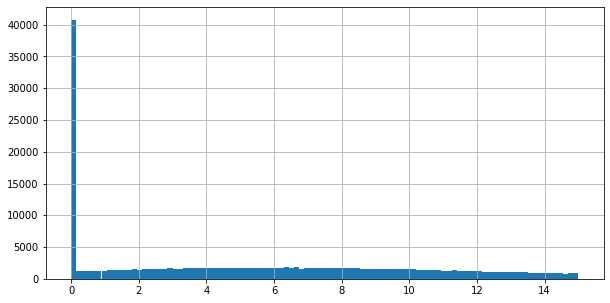

In [14]:
data_calls['duration'].hist(bins=100, range=(0, 15), figsize=(10,5))
plt.show()

Как видим, нулевые значения полностью нарушают все распределение. Выделим ненулевые значения в отдельный датасет и посмотрим, каковы его характеристики.

In [15]:
data_calls_notnull=data_calls.query('duration!=0').copy()
data_calls_notnull['duration'].describe()

count    162994.000000
mean          8.397794
std           5.353022
min           0.010000
25%           4.170000
50%           7.740000
75%          11.850000
max          38.000000
Name: duration, dtype: float64

Как видим, и среднее, и медиана существенно сдвинулись. Построим гистограмму по новым данным.

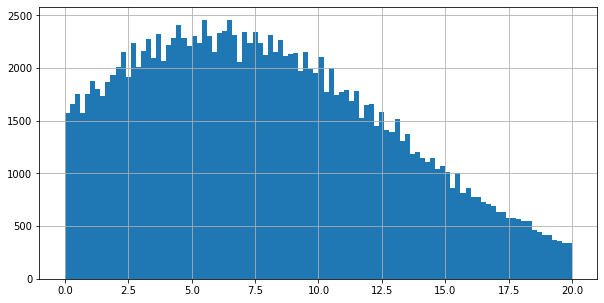

In [16]:
data_calls_notnull['duration'].hist(bins=100, range=(0, 20), figsize=(10,5))
plt.show()

Как видим, распределение приобрело гораздо более информативный вид и теперь похоже на распределение Пуассона, стремящееся к нормальному. В дальнейшем будем работать именно с этими данными.

В завершение работы с этой таблицей округлим значения продолжительности разговора вверх до ближайшего целого числа - как это указано по условиям применямых тарифов (все значения округлаются вверх до целых минут). После этого, т.к. в дальнейшем мы будем работать именно с целыми минутами, приведем данные к целочисленному типу.

In [17]:
data_calls_notnull['duration']=np.ceil(data_calls_notnull['duration'])
data_calls_notnull['duration']=data_calls_notnull['duration'].astype(int)
print(data_calls_notnull.info())
data_calls_notnull.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162994 entries, 2 to 202606
Data columns (total 4 columns):
id           162994 non-null object
call_date    162994 non-null datetime64[ns]
duration     162994 non-null int64
user_id      162994 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.2+ MB
None


,id,call_date,duration,user_id
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000
7,1000_7,2018-08-22,19,1000
8,1000_8,2018-09-15,19,1000


Перейдем к таблице интернет-сессий. Начнем с удаления лишнего столбца с нумерацией.

In [18]:
del data_internet['Unnamed: 0']
data_internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Теперь аналогично предыдущей таблице округлим вверх до ближайшего целого значения в столбце mb_used - в соответствии с условиями тарифов. Также приведем значения к целочисленному типу данных.

In [19]:
data_internet['mb_used']=np.ceil(data_internet['mb_used'])
data_internet['mb_used']=data_internet['mb_used'].astype(int)
data_internet.head()

,id,mb_used,session_date,user_id
0,1000_0,113,2018-11-25,1000
1,1000_1,1053,2018-09-07,1000
2,1000_2,1198,2018-06-25,1000
3,1000_3,551,2018-08-22,1000
4,1000_4,303,2018-09-24,1000


Наконец, приведем значения в столбце session_date к формату даты.

In [20]:
data_internet['session_date']=pd.to_datetime(data_internet['session_date'], format='%Y-%m-%d')
print(data_internet.info())
display(data_internet.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null int64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 4.6+ MB
None


,id,mb_used,session_date,user_id
0,1000_0,113,2018-11-25,1000
1,1000_1,1053,2018-09-07,1000
2,1000_2,1198,2018-06-25,1000
3,1000_3,551,2018-08-22,1000
4,1000_4,303,2018-09-24,1000
5,1000_5,400,2018-10-02,1000
6,1000_6,541,2018-09-07,1000
7,1000_7,416,2018-07-11,1000
8,1000_8,506,2018-10-08,1000
9,1000_9,346,2018-09-03,1000


Теперь перейдем к таблице с данными по отправленным сообщениям.

Единственное, что нам надо сделать здесь - привести значения в столбце message_date к формату даты.

In [21]:
data_messages['message_date']=pd.to_datetime(data_messages['message_date'], format='%Y-%m-%d')
print(data_messages.info())
display(data_messages.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB
None


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


В таблице с данными тарифов ничего, что требовало бы изменений, нет. Перейдем к таблице пользователей.

Здесь также приведем значения в столбце reg_date к формату даты.

In [22]:
data_users['reg_date']=pd.to_datetime(data_users['reg_date'], format='%Y-%m-%d')
print(data_users.info())
display(data_users.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB
None


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


Значения в столбце churn_date, которые есть, также приведем к формату даты

In [23]:
data_users['churn_date']=pd.to_datetime(data_users['churn_date'], format='%Y-%m-%d', errors='ignore')
print(data_users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB
None


### Вычисляем дополнительные значения для каждого пользователя

Начнем с того, что возьмем за основу таблицу пользователей, но оставим только те данные, которые будем использовать: ID, дату прекращения пользования тарифом (нам нужен только месяц), дату регистрации (тоже нужен только месяц), тариф, город. 

In [24]:
user_stats=data_users[['user_id','tariff','city']].copy()
user_stats['reg_month']=pd.DatetimeIndex(data_users['reg_date']).month.copy()
user_stats['churn_month']=pd.DatetimeIndex(data_users['churn_date']).month.copy()
print(user_stats.info())
display(user_stats.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
user_id        500 non-null int64
tariff         500 non-null object
city           500 non-null object
reg_month      500 non-null int64
churn_month    38 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 19.7+ KB
None


,user_id,tariff,city,reg_month,churn_month
0,1000,ultra,Краснодар,5,NaN
1,1001,smart,Москва,11,NaN
2,1002,smart,Стерлитамак,6,NaN
3,1003,ultra,Москва,8,NaN
4,1004,ultra,Новокузнецк,5,NaN
5,1005,smart,Набережные Челны,1,NaN
6,1006,smart,Ульяновск,2,NaN
7,1007,smart,Москва,4,NaN
8,1008,smart,Челябинск,12,NaN
9,1009,smart,Пермь,3,NaN


Заменим пустые значения в столбце churn_month нулями и приведем все к целочисленному формату.

In [25]:
user_stats['churn_month']=user_stats['churn_month'].fillna(0)
user_stats['churn_month']=user_stats['churn_month'].astype(int)
print(user_stats.info())
display(user_stats.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
user_id        500 non-null int64
tariff         500 non-null object
city           500 non-null object
reg_month      500 non-null int64
churn_month    500 non-null int64
dtypes: int64(3), object(2)
memory usage: 19.7+ KB
None


,user_id,tariff,city,reg_month,churn_month
0,1000,ultra,Краснодар,5,0
1,1001,smart,Москва,11,0
2,1002,smart,Стерлитамак,6,0
3,1003,ultra,Москва,8,0
4,1004,ultra,Новокузнецк,5,0
5,1005,smart,Набережные Челны,1,0
6,1006,smart,Ульяновск,2,0
7,1007,smart,Москва,4,0
8,1008,smart,Челябинск,12,0
9,1009,smart,Пермь,3,0


Теперь создадим на основе таблицы с данными о звонках сводную таблицу количества сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя.

In [26]:
#Создаем в исходной таблице новый столбец - месяц, к которому относится запись
data_calls_notnull['month']=pd.DatetimeIndex(data_calls_notnull['call_date']).month
#Используя этот столбец, создаем сводную таблицу
calls_pivot=data_calls_notnull.pivot_table(index = ['user_id','month'], values = 'duration', aggfunc = ['sum','count']).copy()
calls_pivot=calls_pivot.reset_index()
calls_pivot.columns=calls_pivot.columns.droplevel(1)
#Смотрим, что получилось
display(calls_pivot.head(10))

,user_id,month,sum,count
0,1000,5,159,17
1,1000,6,172,28
2,1000,7,340,41
3,1000,8,408,42
4,1000,9,466,46
5,1000,10,350,44
6,1000,11,338,37
7,1000,12,333,38
8,1001,11,430,45
9,1001,12,414,47


Теперь проделаем все аналогичные операции с таблицей данных по интернет-сессиям. За исключением того, что их количество нам не нужно.

In [27]:
#Создаем в исходной таблице новый столбец - месяц, к которому относится запись
data_internet['month']=pd.DatetimeIndex(data_internet['session_date']).month
#Используя этот столбец, создаем сводную таблицу
internet_pivot=data_internet.pivot_table(index = ['user_id','month'], values = 'mb_used', aggfunc = 'sum').copy()
internet_pivot=internet_pivot.reset_index()
#Смотрим, что получилось
display(internet_pivot.head(10))

,user_id,month,mb_used
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,14581
5,1000,10,14717
6,1000,11,14768
7,1000,12,9827
8,1001,11,18452
9,1001,12,14053


Теперь проделаем все то же самое для сообщений.

In [28]:
#Создаем в исходной таблице новый столбец - месяц, к которому относится запись
data_messages['month']=pd.DatetimeIndex(data_messages['message_date']).month
#Используя этот столбец, создаем сводную таблицу
messages_pivot=data_messages.pivot_table(index = ['user_id','month'], values='message_date', aggfunc = 'count').copy()
messages_pivot=messages_pivot.reset_index()
#Смотрим, что получилось
display(messages_pivot.head(10))

,user_id,month,message_date
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4
9,1002,7,11


Теперь совместим таблицу звонков с таблицей интернет-сессий.

In [29]:
total_stats=calls_pivot.merge(internet_pivot, on=['user_id','month'], how='outer')
print(total_stats.info())
display(total_stats.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 5 columns):
user_id    3214 non-null int64
month      3214 non-null int64
sum        3168 non-null float64
count      3168 non-null float64
mb_used    3203 non-null float64
dtypes: float64(3), int64(2)
memory usage: 150.7 KB
None


,user_id,month,sum,count,mb_used
0,1000,5,159.0,17.0,2256.0
1,1000,6,172.0,28.0,23257.0
2,1000,7,340.0,41.0,14016.0
3,1000,8,408.0,42.0,14070.0
4,1000,9,466.0,46.0,14581.0


Теперь добавим сюда же таблицу статистики по СМС.

In [30]:
total_stats=total_stats.merge(messages_pivot, on=['user_id','month'], how='outer')
print(total_stats.info())
display(total_stats.head(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
user_id         3214 non-null int64
month           3214 non-null int64
sum             3168 non-null float64
count           3168 non-null float64
mb_used         3203 non-null float64
message_date    2717 non-null float64
dtypes: float64(4), int64(2)
memory usage: 175.8 KB
None


,user_id,month,sum,count,mb_used,message_date
0,1000,5,159.0,17.0,2256.0,22.0
1,1000,6,172.0,28.0,23257.0,60.0
2,1000,7,340.0,41.0,14016.0,75.0
3,1000,8,408.0,42.0,14070.0,81.0
4,1000,9,466.0,46.0,14581.0,57.0
5,1000,10,350.0,44.0,14717.0,73.0
6,1000,11,338.0,37.0,14768.0,58.0
7,1000,12,333.0,38.0,9827.0,70.0
8,1001,11,430.0,45.0,18452.0,NaN
9,1001,12,414.0,47.0,14053.0,NaN


Наконец, добавим в эту же таблицу данные о пользователях

In [31]:
total_stats=total_stats.merge(user_stats, on='user_id', how='outer')
print(total_stats.info())
display(total_stats.head(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 10 columns):
user_id         3216 non-null int64
month           3214 non-null float64
sum             3168 non-null float64
count           3168 non-null float64
mb_used         3203 non-null float64
message_date    2717 non-null float64
tariff          3216 non-null object
city            3216 non-null object
reg_month       3216 non-null int64
churn_month     3216 non-null int64
dtypes: float64(5), int64(3), object(2)
memory usage: 276.4+ KB
None


,user_id,month,sum,count,mb_used,message_date,tariff,city,reg_month,churn_month
0,1000,5.0,159.0,17.0,2256.0,22.0,ultra,Краснодар,5,0
1,1000,6.0,172.0,28.0,23257.0,60.0,ultra,Краснодар,5,0
2,1000,7.0,340.0,41.0,14016.0,75.0,ultra,Краснодар,5,0
3,1000,8.0,408.0,42.0,14070.0,81.0,ultra,Краснодар,5,0
4,1000,9.0,466.0,46.0,14581.0,57.0,ultra,Краснодар,5,0
5,1000,10.0,350.0,44.0,14717.0,73.0,ultra,Краснодар,5,0
6,1000,11.0,338.0,37.0,14768.0,58.0,ultra,Краснодар,5,0
7,1000,12.0,333.0,38.0,9827.0,70.0,ultra,Краснодар,5,0
8,1001,11.0,430.0,45.0,18452.0,NaN,smart,Москва,11,0
9,1001,12.0,414.0,47.0,14053.0,NaN,smart,Москва,11,0


В этой таблице пропускам соответствуют месяца, когда пользователи не использовали соответствующие услуги. Поэтому заполним пропуски нулями и приведем все к целочисленному типу данных.

In [32]:
total_stats=total_stats.fillna(0)
total_stats.loc[:,'month':'message_date']=total_stats.loc[:,'month':'message_date'].astype(int)
print(total_stats.info())
display(total_stats.head(20))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 10 columns):
user_id         3216 non-null int64
month           3216 non-null int64
sum             3216 non-null int64
count           3216 non-null int64
mb_used         3216 non-null int64
message_date    3216 non-null int64
tariff          3216 non-null object
city            3216 non-null object
reg_month       3216 non-null int64
churn_month     3216 non-null int64
dtypes: int64(8), object(2)
memory usage: 276.4+ KB
None


,user_id,month,sum,count,mb_used,message_date,tariff,city,reg_month,churn_month
0,1000,5,159,17,2256,22,ultra,Краснодар,5,0
1,1000,6,172,28,23257,60,ultra,Краснодар,5,0
2,1000,7,340,41,14016,75,ultra,Краснодар,5,0
3,1000,8,408,42,14070,81,ultra,Краснодар,5,0
4,1000,9,466,46,14581,57,ultra,Краснодар,5,0
5,1000,10,350,44,14717,73,ultra,Краснодар,5,0
6,1000,11,338,37,14768,58,ultra,Краснодар,5,0
7,1000,12,333,38,9827,70,ultra,Краснодар,5,0
8,1001,11,430,45,18452,0,smart,Москва,11,0
9,1001,12,414,47,14053,0,smart,Москва,11,0


Итак, мы собрали всю интересующую нас информацию в одной таблице. Настало время вычислить затраты на связь каждого абонента за каждый месяц.

In [33]:
#Напишем функцию, вычисляющую дополнительные траты на разговоры за месяц
def expenses(row):
    tariff=row['tariff']
    mb=row['mb_used']
    messages=row['message_date']
    minutes=row['count']
    reg_month=row['reg_month']
    churn_month=row['churn_month']
    
    if tariff=='ultra':
        minutes_extra=minutes-3000
        if minutes_extra<0:
            minutes_extra=0
        mb_extra=mb-30720
        if mb_extra<0:
            mb_extra=0
        messages_extra=messages-1000
        if messages_extra<0:
            messages_extra=0
        expenses_total=minutes_extra+messages_extra+math.ceil(mb_extra/1024)*150+1950
    if tariff=='smart':
        minutes_extra=minutes-500
        if minutes_extra<0:
            minutes_extra=0
        mb_extra=mb-15360
        if mb_extra<0:
            mb_extra=0
        messages_extra=messages-50
        if messages_extra<0:
            messages_extra=0
        expenses_total=minutes_extra*3+messages_extra*3+math.ceil(mb_extra/1024)*200+550
        
    return expenses_total

#Применим функцию к нашей таблице
total_stats['expenses_total']=total_stats.apply(expenses, axis=1)

#Посмотрим, что получилось
print(total_stats.info())
display(total_stats.head(20))   

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 11 columns):
user_id           3216 non-null int64
month             3216 non-null int64
sum               3216 non-null int64
count             3216 non-null int64
mb_used           3216 non-null int64
message_date      3216 non-null int64
tariff            3216 non-null object
city              3216 non-null object
reg_month         3216 non-null int64
churn_month       3216 non-null int64
expenses_total    3216 non-null int64
dtypes: int64(9), object(2)
memory usage: 301.5+ KB
None


,user_id,month,sum,count,mb_used,message_date,tariff,city,reg_month,churn_month,expenses_total
0,1000,5,159,17,2256,22,ultra,Краснодар,5,0,1950
1,1000,6,172,28,23257,60,ultra,Краснодар,5,0,1950
2,1000,7,340,41,14016,75,ultra,Краснодар,5,0,1950
3,1000,8,408,42,14070,81,ultra,Краснодар,5,0,1950
4,1000,9,466,46,14581,57,ultra,Краснодар,5,0,1950
5,1000,10,350,44,14717,73,ultra,Краснодар,5,0,1950
6,1000,11,338,37,14768,58,ultra,Краснодар,5,0,1950
7,1000,12,333,38,9827,70,ultra,Краснодар,5,0,1950
8,1001,11,430,45,18452,0,smart,Москва,11,0,1350
9,1001,12,414,47,14053,0,smart,Москва,11,0,550


### Вывод

Мы привели все значения в исходных таблицах к нужным типам, а также выделили в отдельный набор данных записи о звонках с ненулевой длиной, т.к. записи с нулевой длиной вносили существенные искажения в общую статистку звонков. Далее мы составили сводные таблицы по количеству минут разговоров, мегабайт интернет-траффика и отправленных сообщений по каждому абоненту за каждый месяц. Наконец, мы объединили все эти данные в одну таблицу и на их основе рассчитали выручку на каждого абонента за каждый месяц.

## Шаг 3. Проанализируйте данные

Для начала рассмотрим клиентов тарифа "Смарт". Проанализируем, как распределяются показатели использования ими минут, мегабайтов и сообщений в месяц.

Начнем с минут. Выделим их в отдельную совокупность.

In [34]:
minutes_data_smart=total_stats.query('tariff=="smart"')['sum']
print('Среднее количество минут в месяц:',minutes_data_smart.mean())
print('Дисперсия количества минут в месяц:',np.var(minutes_data_smart, ddof=1))
print('Стандартное отклонение количества минут в месяц:',np.std(minutes_data_smart, ddof=1))

Среднее количество минут в месяц: 417.747533632287
Дисперсия количества минут в месяц: 36281.39383644458
Стандартное отклонение количества минут в месяц: 190.4767540579285


Как видим, в среднем абоненты укладываются в выделенное им по тарифу количество минут, но подходят достаточно близко к пороговому значению. Построим гистограмму, чтобы лучше оценить распределение.

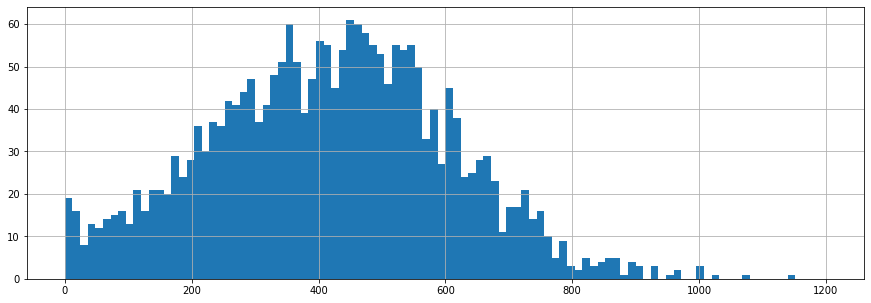

In [35]:
minutes_data_smart.hist(bins=100, figsize=(15,5), range=(0,1200))
plt.show()

Как видим, после локального пика около нуля наблюдается спад, а далее постепенное увеличение количества пользователей. Общий пик наблюдается как раз перед достижением порогового значения включенных в тариф минут, после него начинается более резкое падение, значения больше 1000 минут уже можно считать выбросами. В целом график слегка скошен влево.

Перейдем к анализу количества потраченных в месяц мегабайт. Выделим их в отдельную совокупность и найдем ее характеристики.

In [36]:
mb_data_smart=total_stats.query('tariff=="smart"')['mb_used']
print('Среднее количество мегабайт в месяц:',mb_data_smart.mean())
print('Дисперсия количества мегабайт в месяц:',np.var(mb_data_smart, ddof=1))
print('Стандартное отклонение количества мегабайт в месяц:',np.std(mb_data_smart, ddof=1))

Среднее количество мегабайт в месяц: 16221.910762331838
Дисперсия количества мегабайт в месяц: 34648523.30069166
Стандартное отклонение количества мегабайт в месяц: 5886.299627158955


Как видим, здесь абоненты уже в среднем не укладываются в выделенный по тарифу лимит. Стандартное отклонение меньше относительно среднего значения, чем для минут. 
Построим гистограмму, чтобы лучше оценить распределение.

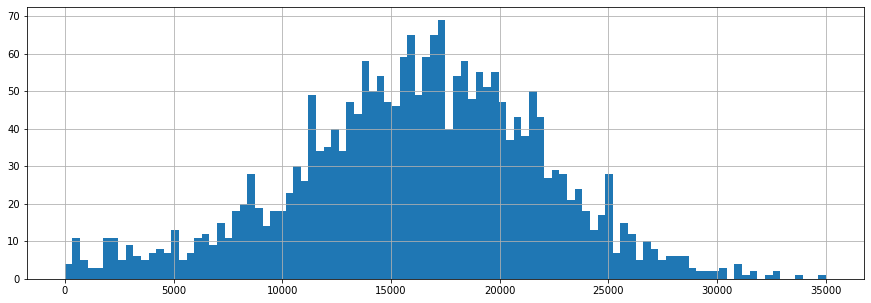

In [37]:
mb_data_smart.hist(bins=100, figsize=(15,5), range=(0,35000))
plt.show()

Здесь видим практически идеальное нормальное распределение с пиком в районе 17 гигабайт. Рост и спад более плавные, чем у предыдущего графика.

Наконец, оценим распределение количества сообщений в месяц.

In [38]:
message_data_smart=total_stats.query('tariff=="smart"')['message_date']
print('Среднее количество сообщений в месяц:',message_data_smart.mean())
print('Дисперсия количества сообщений в месяц:',np.var(message_data_smart, ddof=1))
print('Стандартное отклонение количества сообщений в месяц:',np.std(message_data_smart, ddof=1))

Среднее количество сообщений в месяц: 33.36905829596412
Дисперсия количества сообщений в месяц: 796.9552557301129
Стандартное отклонение количества сообщений в месяц: 28.230395954185852


Как видим, здесь абоненты в среднем укладываются в доступный лимит с запасом. Стандратное отклонение очень велико и почти равно среднему. 
Построим гистограмму, чтобы оценить распределение.

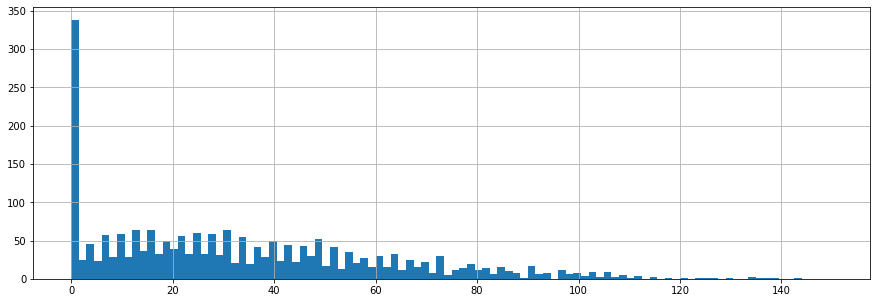

In [39]:
message_data_smart.hist(bins=100, figsize=(15,5), range=(0,150))
plt.show()

Как видим, количество пользователей, вообще не отправляющих сообщения, очень велико. На этом фоне какое-то ощутимое количество пользователей отправляет до 75 сообщений в месяц, далее значения уже становятся несущественными.

Теперь проделаем все то же самое для тарифа "Ультра". 

Начнем с минут. Выделим их в отдельную совокупность и оценим характеристики распределения.

In [40]:
minutes_data_ultra=total_stats.query('tariff=="ultra"')['sum']
print('Среднее количество минут в месяц:',minutes_data_ultra.mean())
print('Дисперсия количества минут в месяц:',np.var(minutes_data_ultra, ddof=1))
print('Стандартное отклонение количества минут в месяц:',np.std(minutes_data_ultra, ddof=1))

Среднее количество минут в месяц: 526.0892494929006
Дисперсия количества минут в месяц: 101052.49354928388
Стандартное отклонение количества минут в месяц: 317.8875485911392


Как видим, среднее количество минут отличается далеко не так сильно, как можно было бы ожидать. По крайней мере, точно не в 6 раз, как количество минут, включенных в тариф. Стандартное отклонение при этом достаточно велико относительно среднего. 
Построим гистограмму, чтобы оценить распределение более наглядно.

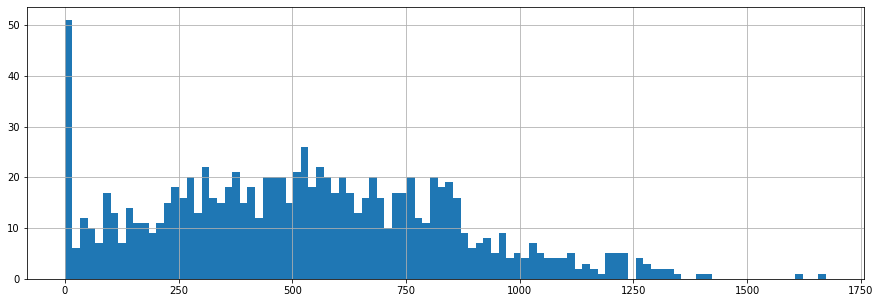

In [41]:
minutes_data_ultra.hist(bins=100, figsize=(15,5))
plt.show()

Довольно неожиданная картина. Самый большой пик приходится на ноль - в течение месяца не было совершено вообще ни одного звонка. Но даже у тех, кто звонки совершает, их не слишком много - значения больше 1300 минут уже можно считать выбросами. Удивительно, но до лимита в 3000 минут не добрался вообще ни один абонент ни в один из месяцев.

Возможно, прояснить такую странную ситуацию поможет анализ количества потраченных в месяц мегабайт. Перейдем к нему.

In [42]:
mb_data_ultra=total_stats.query('tariff=="ultra"')['mb_used']
print('Среднее количество мегабайт в месяц:',mb_data_ultra.mean())
print('Дисперсия количества мегабайт в месяц:',np.var(mb_data_ultra, ddof=1))
print('Стандартное отклонение количества мегабайт в месяц:',np.std(mb_data_ultra, ddof=1))

Среднее количество мегабайт в месяц: 19467.137931034482
Дисперсия количества мегабайт в месяц: 102217264.27537197
Стандартное отклонение количества мегабайт в месяц: 10110.255401095066


Картина не стала существенно яснее, скорее наоборот. Среднее почти не отличается от тарифа "Смарт", а стандартное отклонение очень велико. 
Посмотрим на гистограмму.

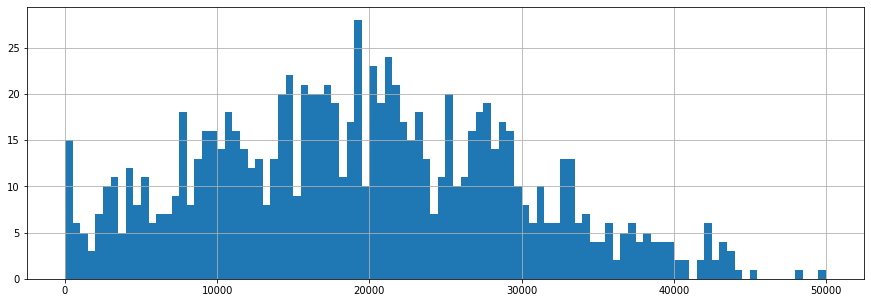

In [43]:
mb_data_ultra.hist(bins=100, figsize=(15,5), range=(0,50000))
plt.show()

Гистограмма характеризуется большим количеством провалов (видимо, из-за меньшего количества пользователей тарифа). Опять же достаточно больтшой пик имеется на нуле, но здесь он хотя бы не затмевает все остальное распределение. В целом распределение похоже на нормальное, месяцы с превышением лимита в 30 гигабайт имеются в некотором количестве. Значения ближе к 50 Гб уже можно считать выбросами.

Наконец оценим, как обстоят дела с сообщениями.

In [44]:
message_data_ultra=total_stats.query('tariff=="ultra"')['message_date']
print('Среднее количество сообщений в месяц:',message_data_ultra.mean())
print('Дисперсия количества сообщений в месяц:',np.var(message_data_ultra, ddof=1))
print('Стандартное отклонение количества сообщений в месяц:',np.std(message_data_ultra, ddof=1))

Среднее количество сообщений в месяц: 49.31338742393509
Дисперсия количества сообщений в месяц: 2285.4174246558414
Стандартное отклонение количества сообщений в месяц: 47.80603962530092


Вновь видим картину, когда объем потребляемых услуг больше, чем в тарифе "Смарт", но увеличение объема совершенно несопоставимо с увеличением включенного лимита. Здесь при включенном лимите в 1000 сообщений в среднем отправляется 49. Также обращает на себя внимание очень большое по сравнению со средним стандартное отклоение, почти равное ему. 
Посмотрим на гистограмму.

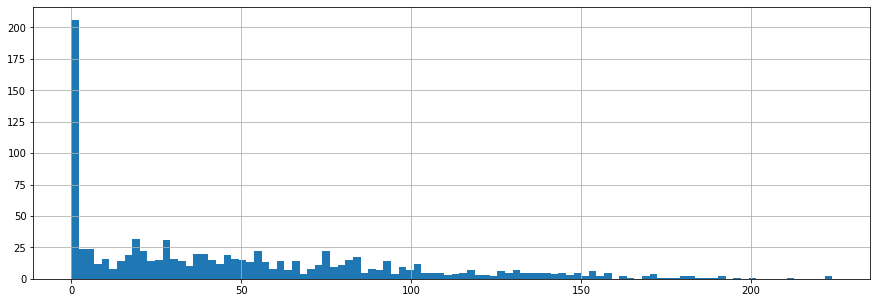

In [45]:
message_data_ultra.hist(bins=100, figsize=(15,5))
plt.show()

Пик на нуле не менее впечатляющий, чем для тарифа "Смарт". Ни один абонент ни в одном месяце не добрался даже до 250 сообщений, что уж говорить про 1000. В целом распределение имеет странный вид с чередующимися пиками и провалами, видимо из-за не очень большого количества данных.

### Вывод

Из того, что мы увидели на этом шаге, тариф "Ультра" кажется более выгодным для оператора: его абоненты платят более чем в три раза больше, чем абоненты тарифа "Смарт", а за границы включенных лимитов редко выбираются и те и другие. Впрочем, на тариф "Смарт" приходится единственный на все рассмотренные множества случай превышения средним порогового значения для тарифа: в среднем его абоненты в месяц используют 16 Гб интернета, а в тариф включено 15. Сможет ли это превышение компенсировать более низкую абонентскую плату, мы узнаем на следующем шаге.

### Шаг 4. Проверьте гипотезы

#### Предварительные расчеты

На предыдущем шаге мы изучили вопрос, как отличаются потребляемые пользователями двух тарифов услуги. Настало время сделать следующий шаг и рассмотреть, как различаются их ежемесячные платежи. Начнем с выделения этой информации в отдельные совокупности.

In [46]:
#Выделим совокупности, которые мы будем сравнивать
gross_smart=total_stats.query('tariff=="smart"')['expenses_total']
gross_ultra=total_stats.query('tariff=="ultra"')['expenses_total']

Чтобы иметь представление о том, что мы сравниваем, посмотрим, сколько всего пользователей у каждого из тарифов, и сколько всего месяцев они суммарно пользовались этими тарифами.

In [47]:
print('Всего пользователей тарифа "Смарт":',len(data_users.query('tariff=="smart"')['tariff']))
print('Всего пользователей тарифа "Ультра":',len(data_users.query('tariff=="ultra"')['tariff']))
print('Всего месяцев пользования тарифом "Смарт":',len(gross_smart))
print('Всего месяцев пользования тарифом "Ультра":',len(gross_ultra))                                                                  

Всего пользователей тарифа "Смарт": 351
Всего пользователей тарифа "Ультра": 149
Всего месяцев пользования тарифом "Смарт": 2230
Всего месяцев пользования тарифом "Ультра": 986


Как видим, пользователей тарифа "Смарт" более чем в два раза больше, что неудивительно, учитывая разницу в абонентской плате.
<br />Теперь исследуем характеристики распределения ежемесячных платежей по тарифам.

In [48]:
print(gross_smart.describe())
print(gross_ultra.describe())

count    2230.000000
mean     1169.544395
std       743.367864
min       550.000000
25%       550.000000
50%       950.000000
75%      1550.000000
max      5249.000000
Name: expenses_total, dtype: float64
count     986.000000
mean     2070.943205
std       378.629673
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: expenses_total, dtype: float64


Дла тарифа "Смарт" среднее равно 1169 рублям, а медиана - 950 рублям. Обращаем на себя внимание очень высокое стандартное отклонение - 743 рубля.
<br/>В тарифе "Ультра" все гораздо проще - значения группируются вокруг стандартной абонентской платы в 1950 рублей, ей равны первый, второй и третий квартили. Среднее равно 2070 рублям. Стандартное отклонение почти в два раза меньше, чем для тарифа "Смарт", и равно 378 рублям.
<br/>Любопытно, что максимум для тарифа "Смарт" больше, чем для тарифа "Ультра".
<br/>Для большей наглядности построим гистограммы распределения значений ежемесячной платы для пользователей обоих тарифов

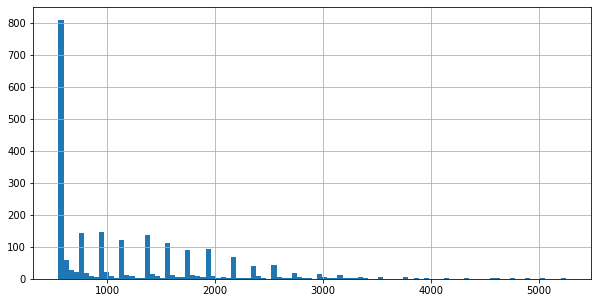

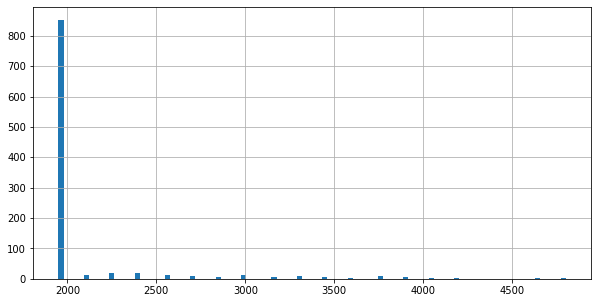

In [49]:
gross_smart.hist(bins=100, figsize=(10,5))
plt.show()
gross_ultra.hist(bins=100, figsize=(10,5))
plt.show()

Как видно из гистограмм, в тарифе "Смарт", хотя самый большой пик приходится на стандартный размер абонентской платы, есть хорошо заметные и ощутимые пики на значениях, соответствующих дополнительным гигабайтам интернет-трафика (т.к. там сразу прибавляется 200 рублей, они хорошо видны).
<br/>Что касается тарифа "Ультра", здесь пик на минимальном значении в 1950 рублей настолько велик, что все остальные значения на таком масштабе едва различимы.

#### Проверка гипотез

В качестве нулевой гипотезы примем, что средняя выручка пользователей двух тарифов равна. В качестве альтернативной - что она различается. Встает вопрос - равны ли дисперсии выборок? От этого будет зависеть параметр, который нам надо будет указать.
<br/>Мы уже выяснили, что стандартные отклонения отличаются почти в два раза, но для надежности зафиксируем цифры для дисперсий.

In [51]:
print('Дисперсия выборки ежемесячных расходов пользователей тарифа "Смарт"',gross_smart.var())
print('Дисперсия выборки ежемесячных расходов пользователей тарифа "Смарт"',gross_ultra.var())

Дисперсия выборки ежемесячных расходов пользователей тарифа "Смарт" 552595.7815634513
Дисперсия выборки ежемесячных расходов пользователей тарифа "Смарт" 143360.42925834784


Итак, дисперсии различаются почти в 4 раза. Этого более чем достаточно, чтобы считать их неравными друг другу в дальнейшем.

In [52]:
#Зададим критический уровень статистической значимости
alpha=0.05
#Проводим сравнение
results = st.ttest_ind(gross_smart, gross_ultra, equal_var=False)
#Выводим результаты
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0
Отвергаем нулевую гипотезу


Впечатляюще. Мы имеем нулевую вероятность того, что средние двух совокупностей равны. Теперь нужно понять, какой же из тарифов выгоднее. 
Для этого нам нужно конкретное значение выручки, от которого мы можем отталкиваться. Как мы уже сказали выше, пользователи тарифа "Ультра" редко выходят за пределы установленных им лимитов. Но платят они в любом случае не меньше 1950 рублей - никаких способов снизить абонентскую плату в условиях тарифов не указано. Значит нам нужно проверить гипотезу о том, что пользователи тарифа "Смарт" платят меньше 1950 рублей в месяц. Если эта гипотеза не будет отвергнута, значит можно будет считать, что пользователи тарифа "Смарт" платят меньше пользователей тарифа "Ультра".
Итак, нулевая гипотеза - средняя выручка для пользователей тарифа "Смарт" равна 1950 рублей. Альтернативная - средняя выручка меньше 1950 рублей.

In [53]:
#Задаем пороговое значение - 1950 рублей
interested_value = 1950
#Задаем критический уровень статистической значимости
alpha = 0.05
#Проводим сравнение
results_2 = st.ttest_1samp(gross_smart,interested_value)
#Выводим результаты
print('p-значение:', results.pvalue/2)
if (results_2.pvalue/2 < alpha) and (gross_smart.mean() < interested_value):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0
Отвергаем нулевую гипотезу


Как видим, мы можем с достаточной долей вероятности отвергнуть нулевую гипотезу, значит средняя выручка для абонентов тарифа "Смарт" значимо меньше 1950 рублей, а следовательно, тариф "Ультра" выгоднее для оператора.

Теперь проверим гипотезу о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. В данном случае наша нулевая гипотеза состоит в том, что выручка одинакова, а альтернативная - что она отличается. Действовать будем аналогично тому, что делали в начале сравнения выручки для пользователей двух тарифов. Сначала также проверим, насколько существенно различаются дисперсии для выборок.

In [54]:
#Выделим совокупности, которые мы будем сравнивать
gross_moscow=total_stats.query('city=="Москва"')['expenses_total']
gross_regions=total_stats.query('city!="Москва"')['expenses_total']
#Сравним дисперсии
print('Дисперсия выборки ежемесячных расходов пользователей из Москвы',gross_moscow.var())
print('Дисперсия выборки ежемесячных расходов пользователей из регионов',gross_regions.var())

Дисперсия выборки ежемесячных расходов пользователей из Москвы 561376.013785517
Дисперсия выборки ежемесячных расходов пользователей из регионов 608810.3316312421


Отличие меньше, чем в предыдущем случае, но по-прежнему достаточно велико, чтобы считать дисперсии неравными, оно составляет около 8%. Переходим непосредственно к проверке гипотезы.

In [55]:
#Зададим критический уровень статистической значимости
alpha=0.05
#Проводим сравнение
results = st.ttest_ind(gross_moscow, gross_regions, equal_var=False)
#Выводим результаты
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.27357188086762696
Не получилось отвергнуть нулевую гипотезу


Как видим, имеющиеся данные не дают нам оснований отвергнуть гипотезу о том, что средняя выручка пользователей из Москвы и средняя выручка пользователей из других регионов отличаются.

### Вывод

В ходе проверок наших гипотез мы выяснили, что средняя выручка пользователей тарифов "Смарт" и "Ультра" вероятно отличается, а средняя выручка пользователей из Москвы вероятно не отличается от выручки пользователей из других регионов.

## Шаг 5. Напишите общий вывод

В ходе проведенного исследования мы обработали данные по 500 абонентов двух тарифных планов. Мы изучили данные, привели их к нужным типам и отбросили звонки, имеющие нулевую продолжительность (таких в исследуемой совокупности выявилось очень много) - вероятно, это пропущенные звонки, они не тарифицируются. 
Далее мы посчитали для каждого пользователя помесячное количество сделанных звонков и минут разговоров, мегабайт потраченного интернет-трафика, отправленных сообщений. Далее на основе этих данных посчитали помесячную выручку для каждого пользователя.
Наконец, мы проверили гипотезы и пришли к выводу, что статистически оправдано сделать вывод о том, что тариф "Ультра" выгоднее для оператора, чем тариф "Смарт". Гипотеза о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов, на имеющихся данных не подтвердилась.